In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import_path = "/Users/michalmacbookpro/Downloads/titanic/"
train = pd.read_csv(import_path + "train.csv",index_col="PassengerId")
test = pd.read_csv(import_path + "test.csv",index_col="PassengerId")
submision = pd.read_csv(import_path + "gender_submission.csv")

In [3]:
train[["man","woman"]] = pd.get_dummies(train["Sex"])
train[["1","2","3"]] = pd.get_dummies(train["Pclass"])
train[["c","q","s"]] = pd.get_dummies(train["Embarked"])

def cabinizer(df):
    df["Cabin_L"] = df["Cabin"].str.extract(r"(^\D{0,1})")
    df["Cabin_L"].fillna("U",inplace=True)
    df["Cabin_L"] = df["Cabin_L"].map({"A":"ABC","B":"ABC","C":"ABC","D":"DE","E":"DE","F":"FG","G":"FG","T":"ABC","U":"U"})
    return df

def familiazer(df):
    df["Family"] = df["SibSp"] + df["Parch"]
    df["Family"] = df["Family"]
    return df


def aloniazer(df):
    df["Alone"] = 0
    df.loc[df["Family"]==0,"Alone"] = 1
    return df

cabinizer(train)
familiazer(train)
aloniazer(train)

train[["ABC","DE","FG","U"]] = pd.get_dummies(train["Cabin_L"])

to_drop = ["Pclass","Name","Sex","SibSp","Parch","Ticket","Cabin","Embarked","Cabin_L","Family","2","q","FG","woman"]
train.drop(to_drop,inplace=True,axis=1)

train["Age"].fillna(np.mean(train["Fare"]),inplace=True)
mean_fare = np.mean(train["Fare"])
std_fare = np.std(train["Fare"])
mean_age = np.mean(train["Age"])
std_age = np.std(train["Age"])

train["Age"] = (train["Age"] - mean_age)/std_age

train["Fare"] = (train["Fare"] - mean_fare)/std_fare
train.sample(15)

,Survived,Age,Fare,man,1,3,c,s,Alone,ABC,DE,U
PassengerId,,,,,,,,,,,,
303,0,-0.859102,-0.648422,0,0,1,0,1,1,0,0,1
618,0,-0.322008,-0.324253,1,0,1,0,1,0,0,0,1
455,0,0.154027,-0.486337,0,0,1,0,1,1,0,0,1
792,0,-1.089285,-0.124920,0,0,0,0,1,1,0,0,1
135,0,-0.398736,-0.386671,0,0,0,0,1,1,0,0,1
51,0,-1.779835,0.150674,0,0,1,0,1,0,0,0,1
501,0,-1.012558,-0.474005,0,0,1,0,1,1,0,0,1
718,1,-0.245280,-0.437007,1,0,0,0,1,1,0,1,0
629,0,-0.322008,-0.489442,0,0,1,0,1,1,0,0,1


In [4]:
y = train["Survived"]
X = train.drop(["Survived"],axis=1)

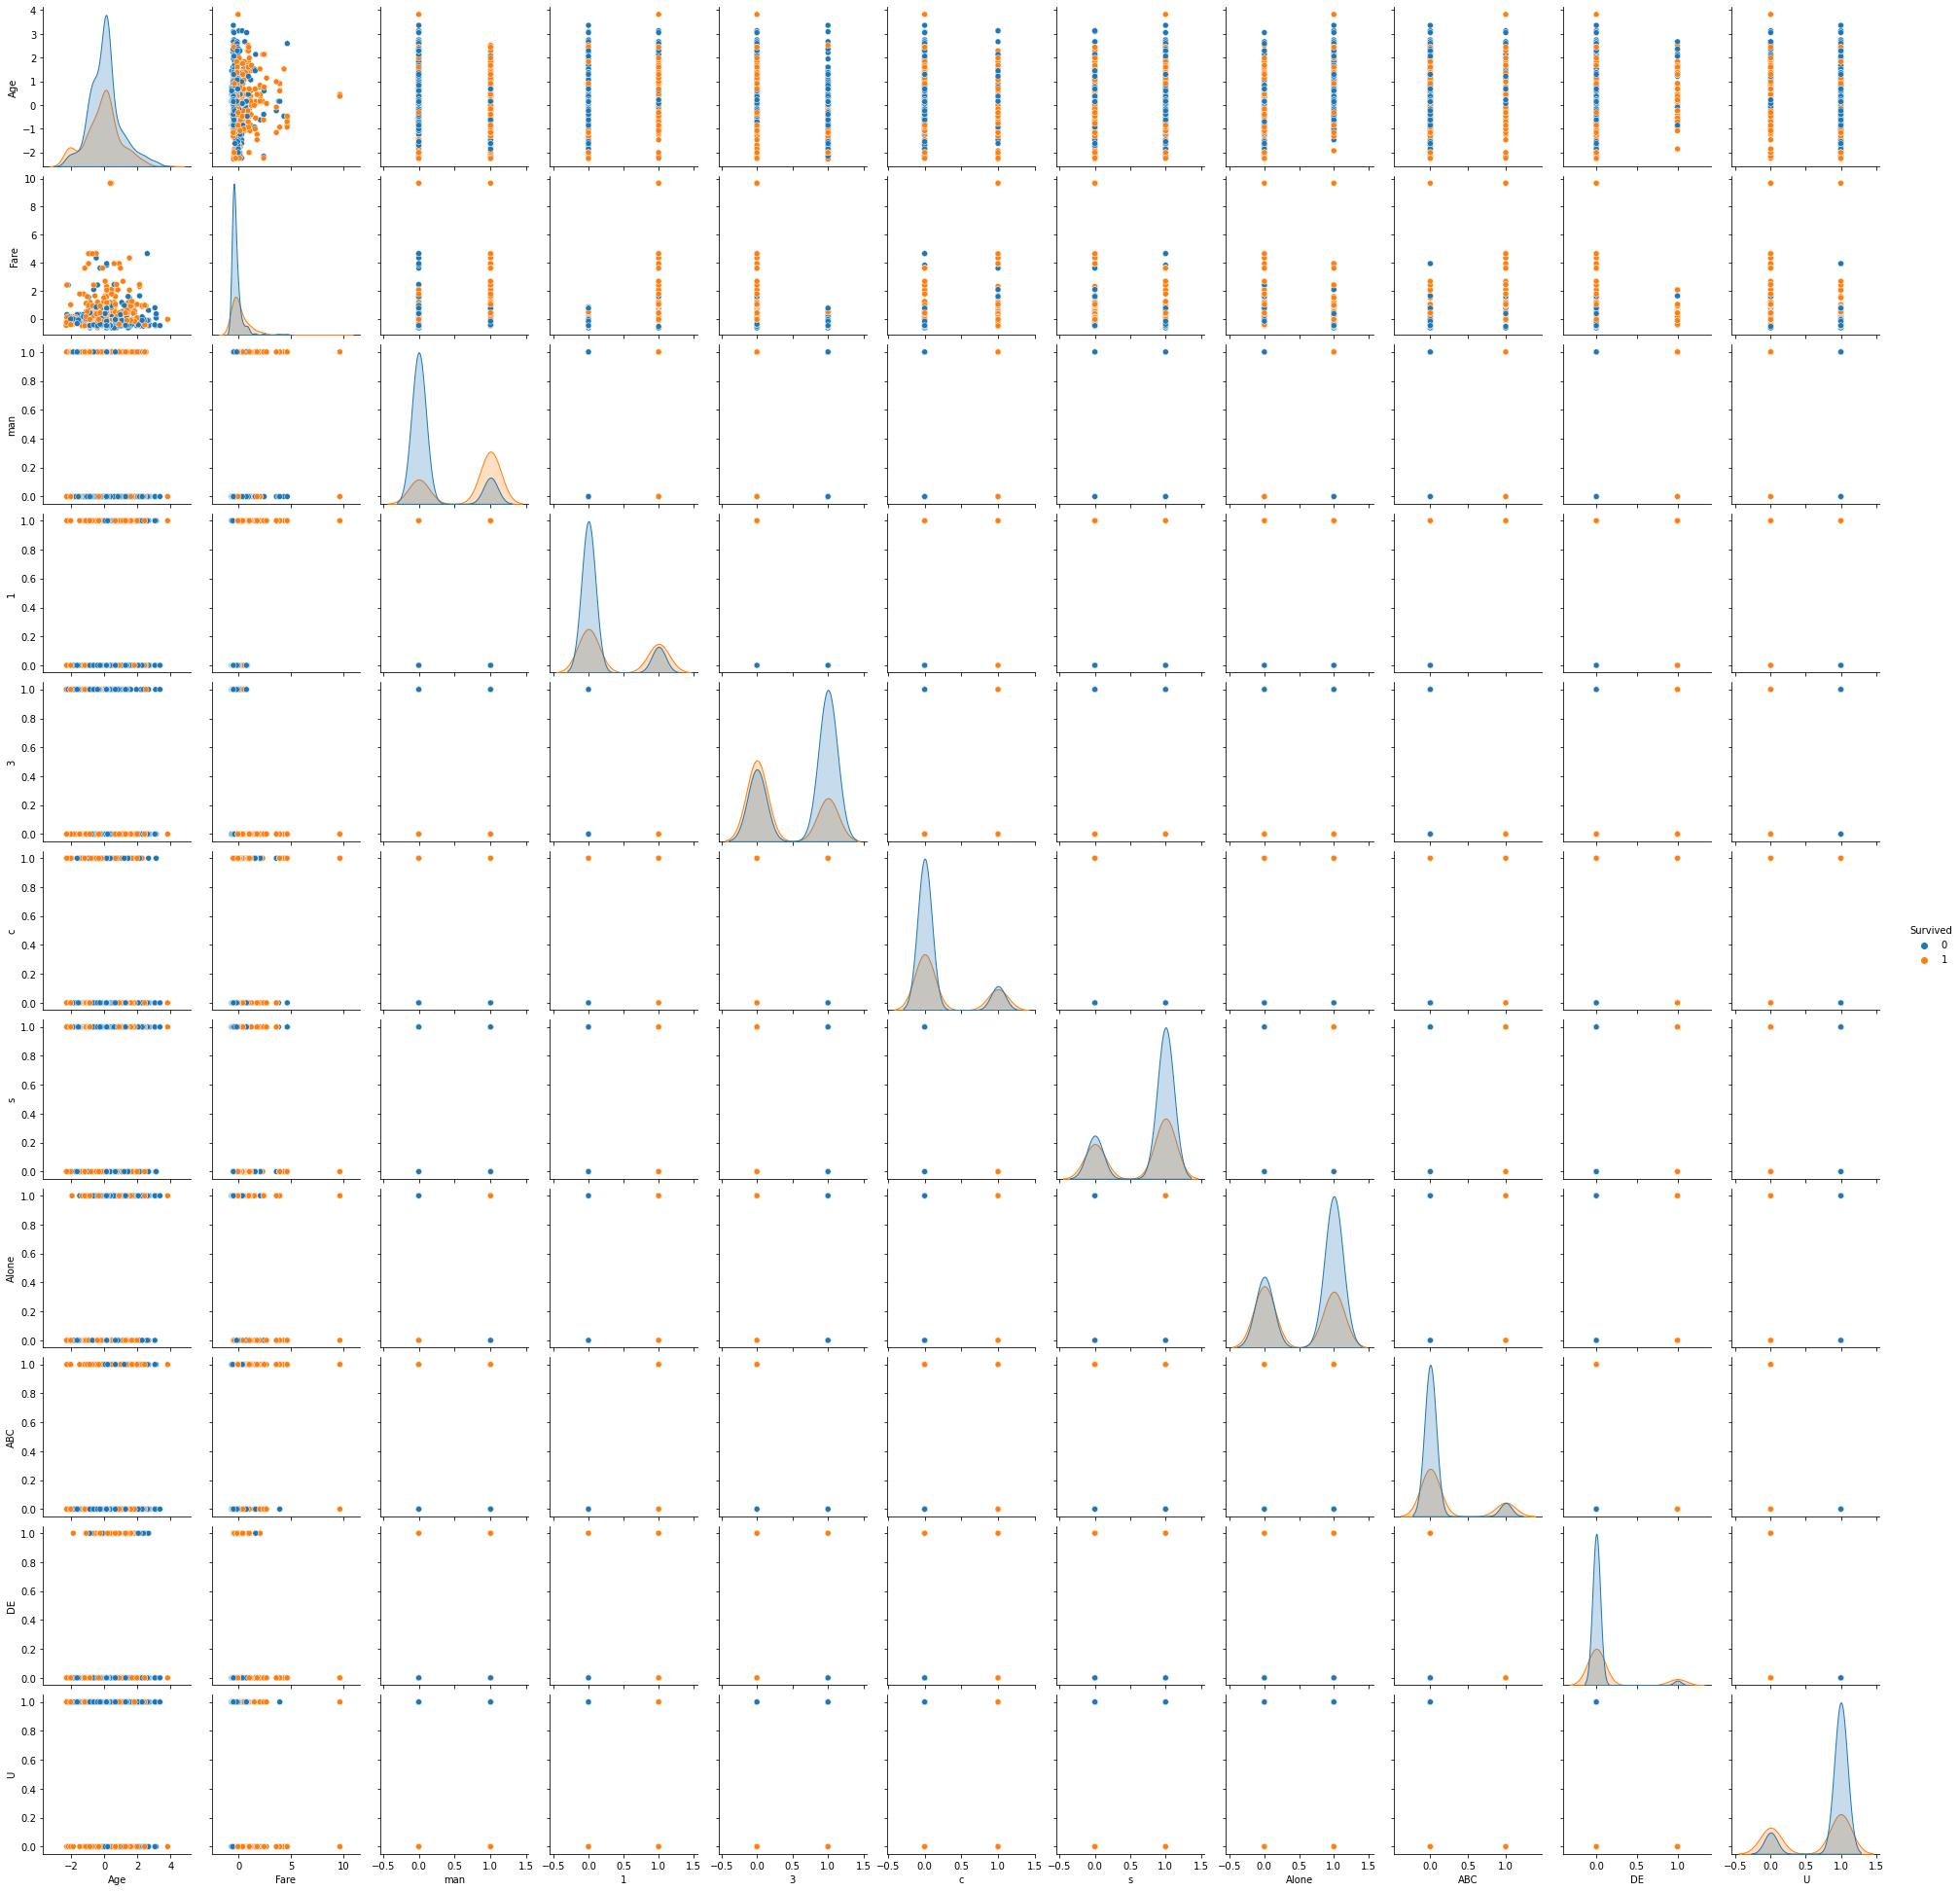

In [34]:
sns.pairplot(data=train, hue="Survived")

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
#resample nie je aplikovatelne, je to celkom vyrovnane, potom ako posledne
#bagging
from sklearn.ensemble import BaggingClassifier
#halvin random search
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.linear_model import LogisticRegression

/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [7]:
rfc = RandomForestClassifier()
dtc = DecisionTreeClassifier()

In [8]:
dtc2 = DecisionTreeClassifier(criterion="entropy",max_depth=8)
ada = AdaBoostClassifier(base_estimator=dtc2,learning_rate=0.2,n_estimators=200)
#
ada.fit(X_train,y_train)
y_pred_0 = ada.predict(X_test)
print(accuracy_score(y_pred_0, y_test))

0.7723880597014925


In [9]:
dtc2 = DecisionTreeClassifier(criterion="gini",max_depth=8)
bag = BaggingClassifier(base_estimator=dtc2,n_estimators=150,n_jobs=-1)
bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)
print(accuracy_score(y_pred_bag,y_test))

0.8022388059701493


In [10]:
param = [{
    "criterion": ['gini', 'entropy'],
    "n_estimators":[200,300,400,500],
    'max_depth': range(4, 20, 2),
    'max_leaf_nodes': range(4, 28, 2),
}]
#
gs_rt = GridSearchCV(rfc, param, cv = 5, n_jobs = -1, verbose = 1)
gs_rt.fit(X_train, y_train)
y_pred_rfc = gs_rt.predict(X_test)
print(gs_rt.best_estimator_)
print(accuracy_score(y_pred_rfc,y_test))
rt_rs_best = gs_rt.best_estimator_

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
RandomForestClassifier(max_depth=8, max_leaf_nodes=18, n_estimators=200)
0.8097014925373134


In [11]:
print(accuracy_score(y_pred_rfc,y_test))

0.8097014925373134


In [12]:
param = [
    {
        'criterion': ['gini', 'entropy'],
        'max_depth': range(2, 20, 2),
        'max_leaf_nodes': range(4, 28, 2),
    }
]
#
gs_dt = GridSearchCV(dtc, param, cv = 5, n_jobs = -1, verbose = 1,scoring="accuracy")
gs_dt.fit(X_train, y_train)
y_pred = gs_dt.predict(X_test)
print(accuracy_score(y_pred,y_test))
dt_gs_best = gs_dt.best_estimator_
print(gs_dt.best_estimator_)
#print(accuracy_score(y_pred,y_test))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
0.7910447761194029
DecisionTreeClassifier(criterion='entropy', max_depth=4, max_leaf_nodes=18)


In [13]:
from sklearn.svm import SVC

svc = SVC()

param = [
    {
        'kernel': ['rbf'], 
        'C': [0.1, 0.3, 1, 2, 3, 4], 
        'gamma': [0.1,0.2,0.3]
    }, 
]

svc = SVC(probability = True)
rs_svc = GridSearchCV(svc, param, cv =5, n_jobs = -1, verbose = 1)
rs_svc.fit(X_train, y_train)
y_pred = rs_svc.predict(X_test)
print(accuracy_score(y_pred,y_test))
svc_best = rs_svc.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
0.8097014925373134


In [14]:
param = [
    {
        'criterion': ['gini', 'entropy'],
        'max_depth': range(2, 20, 2),
        'max_leaf_nodes': range(4, 28, 2),
    }
]
#
hs = HalvingRandomSearchCV(dtc,
            param_distributions=param,
            n_candidates='exhaust',
            resource='n_samples',
            factor=1.3,
            random_state=1,
            n_jobs=-1)
#
hs.fit(X_train,y_train)
y_pred_hs = hs.predict(X_test)
print(accuracy_score(y_pred_hs,y_test))

0.7873134328358209


In [15]:
param = [
    {'n_estimators': range(8, 28, 4), 
     'max_depth': range(24, 48, 4),
     'max_leaf_nodes': range(20, 48, 4),
    }
]
#
et = ExtraTreesClassifier()
gs_et = RandomizedSearchCV(et, param, cv = 5, n_jobs = -1, verbose = 1)
gs_et.fit(X_train, y_train)
y_pred = gs_et.predict(X_test)
print(accuracy_score(y_pred,y_test))
print(gs_et.best_estimator_)
extra_best = gs_et.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.8097014925373134
ExtraTreesClassifier(max_depth=28, max_leaf_nodes=20, n_estimators=8)


In [16]:
param_grid={
    'max_depth': range(2, 10, 2),
    'n_estimators': range(26, 46, 2),
    'learning_rate': [0.2, 0.1, 0.03, 0.01]
}
#
xg = XGBClassifier(eval_metric='logloss', n_jobs = -1, use_label_encoder = False)
gs_xg = RandomizedSearchCV(xg, param_grid, cv = 5, n_jobs = -1, verbose = 1)
gs_xg.fit(X_train, y_train)
y_pred = gs_xg.predict(X_test)
print(accuracy_score(y_pred,y_test))
xboo_best = gs_xg.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype inste

0.8059701492537313


In [17]:
lr = LogisticRegression()

lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)
print(accuracy_score(y_pred_lr,y_test))

0.7947761194029851


In [18]:
voting_clf = VotingClassifier(estimators=[
    ("rand_for",rt_rs_best),
    ("dec_tree",dt_gs_best),
    ("svc",svc_best),
    ("extree",extra_best),
    ("xgb",xboo_best),
    ("ada",ada),
    ("bag",bag)],
    voting = 'soft', n_jobs = -1, verbose = 1)
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
print(accuracy_score(y_pred,y_test))

[Voting] ................. (2 of 7) Processing dec_tree, total=   0.0s
[Voting] ................... (4 of 7) Processing extree, total=   0.0s
[Voting] ...................... (3 of 7) Processing svc, total=   0.1s
[Voting] ................. (1 of 7) Processing rand_for, total=   0.2s


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[Voting] ...................... (5 of 7) Processing xgb, total=   0.2s
[Voting] ...................... (7 of 7) Processing bag, total=   0.2s
[Voting] ...................... (6 of 7) Processing ada, total=   0.3s
0.8134328358208955


In [19]:
test = pd.read_csv(import_path + "test.csv",index_col="PassengerId")

test[["man","woman"]] = pd.get_dummies(test["Sex"])
test[["1","2","3"]] = pd.get_dummies(test["Pclass"])
test[["c","q","s"]] = pd.get_dummies(test["Embarked"])

def cabinizer(df):
    df["Cabin_L"] = df["Cabin"].str.extract(r"(^\D{0,1})")
    df["Cabin_L"].fillna("U",inplace=True)
    df["Cabin_L"] = df["Cabin_L"].map({"A":"ABC","B":"ABC","C":"ABC","D":"DE","E":"DE","F":"FG","G":"FG","T":"ABC","U":"U"})
    return df

def familiazer(df):
    df["Family"] = df["SibSp"] + df["Parch"]
    df["Family"] = df["Family"]
    return df


def aloniazer(df):
    df["Alone"] = 0
    df.loc[df["Family"]==0,"Alone"] = 1
    return df

cabinizer(test)
familiazer(test)
aloniazer(test)

test[["ABC","DE","FG","U"]] = pd.get_dummies(test["Cabin_L"])

to_drop = ["Pclass","Name","Sex","SibSp","Parch","Ticket","Cabin","Embarked","Cabin_L","Family","2","q","FG","woman"]
test.drop(to_drop,inplace=True,axis=1)

test["Age"].fillna(np.mean(test["Fare"]),inplace=True)
test["Fare"].fillna(np.mean(test["Fare"]),inplace=True)
mean_fare = np.mean(test["Fare"])
std_fare = np.std(test["Fare"])
mean_age = np.mean(test["Age"])
std_age = np.std(test["Age"])
test["Age"] = (test["Age"] - mean_age)/std_age

test["Fare"] = (test["Fare"] - mean_fare)/std_fare
test.sample(15)


submision["Survived"] = voting_clf.predict(test).astype("int")
submision.to_csv('submission.csv', index = False)

In [20]:
from sklearn.decomposition import PCA

In [21]:
pca = PCA(n_components=3)

In [22]:
pca_D = pca.fit_transform(X_train)

In [23]:
X_test_pca = pca.transform(X_test)

In [24]:
pca_D

array([[ 0.43806711,  1.05190779, -0.68776305],
       [-0.62725195, -0.52278954, -0.15946201],
       [-0.44392748, -0.32191121,  0.68231017],
       ...,
       [ 0.45127882, -0.94787815, -0.22387747],
       [ 1.20512379, -1.09242778, -0.5249842 ],
       [ 0.1403853 ,  0.94410251, -0.5161489 ]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


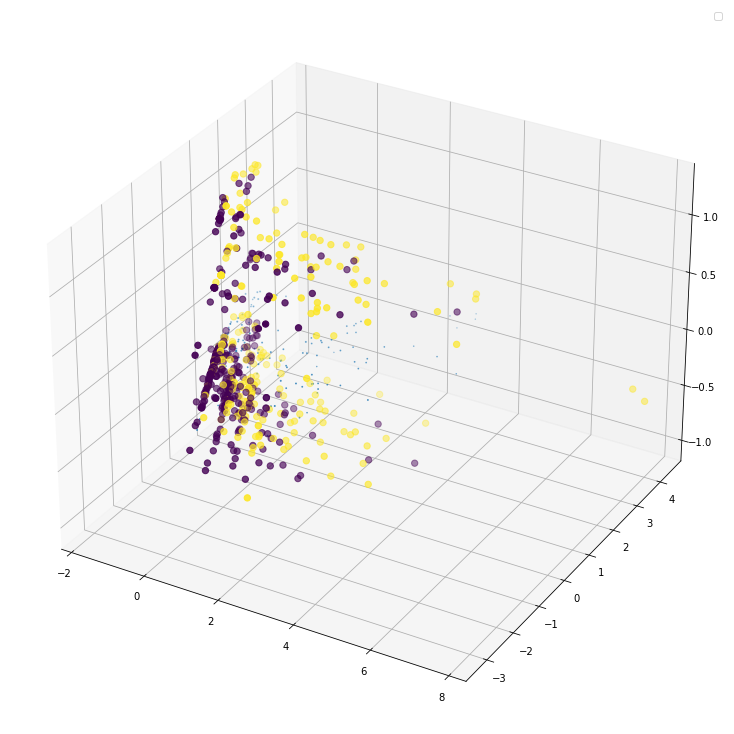

In [25]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)

x=pca_D[:,0]
y=pca_D[:,1]
z=pca_D[:,2]
sc= ax.scatter(x,y,z,s=40,c=y_train)
plt.legend()
plt.scatter(x,y,z)

In [26]:
lr.fit(pca_D,y_train)
y_pred_pca = lr.predict(X_test_pca)
print(accuracy_score(y_pred_pca,y_test))

0.6567164179104478


In [27]:
svc.fit(pca_D,y_train)
y_pred_pca = svc.predict(X_test_pca)
print(accuracy_score(y_pred_pca,y_test))

0.6529850746268657


In [28]:
rfc.fit(pca_D,y_train)
y_pred_pca = rfc.predict(X_test_pca)
print(accuracy_score(y_pred_pca,y_test))

0.6977611940298507


In [29]:
X_train

,Age,Fare,man,1,3,c,s,Alone,ABC,DE,U
PassengerId,,,,,,,,,,,
749,-0.859102,0.420730,0,1,0,0,1,0,0,1,0
46,0.154027,-0.486337,0,0,1,0,1,1,0,0,1
29,0.154027,-0.489776,1,0,1,0,0,1,0,0,1
634,0.154027,-0.648422,0,1,0,0,1,1,0,0,1
404,-0.168553,-0.329287,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
477,0.291814,-0.225593,0,0,0,0,1,0,0,0,1
191,0.138358,-0.386671,1,0,0,0,1,1,0,0,1
737,1.366002,0.043708,1,0,1,0,1,0,0,0,1
